In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from diffusers.optimization import SchedulerType, TYPE_TO_SCHEDULER_FUNCTION

from tqdm import tqdm

seed_value = 42 

# Setting the seed in PyTorch
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Setting the seed in NumPy
np.random.seed(seed_value)

In [2]:
from IPython.core.display import display, HTML

display(HTML("""
<style>
    div.output_scroll {
        height: auto !important;
    }
</style>
"""))

/tmp/ipykernel_738513/229815420.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## 0. Introduction

Welcome to this Jupyter notebook where we explore and compare various generative-model-based policies for robotic learning, focusing on Diffusion Policy (DDIM), 1-RF (1-Rectified Flow), and AdaFlow. 

### Overview 

- **Section 1:** We demonstrate a nice property of 1-Rectified Flow over the traditional Diffusion Policy. Specifically, we show how the ODE trajectory simulated by Rectified Flow forms a straight line when the prediction is deterministic. This characteristic inspired our development of AdaFlow. 

- **Section 2:** Building on the foundational understanding from Section 1, we build AdaFlow. Here, we illustrate how AdaFlow employs a variance-adaptive ODE solver that adjusts to the uncertainty of the generation, and it reduces to a one-step generation process in deterministic (uni-modal) scenarios.

## 1. The Nice Property of Rectified Flow: Variance Equals Straightness

In this section, we show a key characteristic of 1-Rectified Flow. 

Specifically, we explore a predictive task where the goal is to determine the value of $y$ given $x$.

For the cases where $x \le 0$ the relationship is deterministic, with $y$ consistently equaling 0, indicating zero variance. when $x>0$, $y$ becomes bimodal, with $y=\pm x$. This introduces increasing variance when $x>0$. 

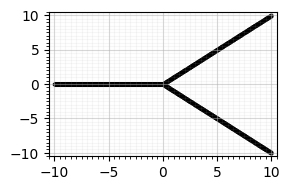

In [3]:
def ftrue(x):
    if np.random.rand() > 0.5:
        return np.maximum(x, 0)
    else:
        return -np.maximum(x, 0)

plt.figure(figsize=(3, 2))

# plot the true y values
Nsample = 10000
x = np.linspace(-10, 10, Nsample)
y = np.array([ftrue(xi) for xi in x])
plt.scatter(x, y, color='k', s=4, alpha=0.1)

plt.xlim(-10.5, 10.5)
plt.ylim(-10.5, 10.5)

plt.xticks([-10, -5.0, 0, 5.0, 10], fontsize=10)
plt.yticks([-10, -5.0, 0, 5.0, 10], fontsize=10)

ax = plt.gca() 
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.5)
plt.tight_layout()
plt.show()

# Create synthetic dataset
Nsample = 10000
x = np.linspace(-10, 10, Nsample)[:, np.newaxis].astype('float32')
y = np.array([ftrue(xi) for xi in x]).astype('float32')
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# hyperparams
batch_size = 1000
num_epochs = 200
num_warmup_steps = 10
lr = 1e-2

dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

name = SchedulerType("cosine")
schedule_func = TYPE_TO_SCHEDULER_FUNCTION[name]

In [4]:
# Let's start by defining a policy network
class MLP(nn.Module):
    def __init__(
        self,
        num_in,
        num_out,
        num_hid=500,
        ):
        super().__init__()
        self.num_in = num_in
        self.num_hid = num_hid
        self.num_out = num_out

        self.rdFrequency = torch.normal(0, 1, (1, 100))

        self.net = nn.Sequential(
            nn.Linear(num_in + num_out + 100 , num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_out)
        )

    def forward(self, noisy_y, timesteps, cond=None):
        if not torch.is_tensor(timesteps):
            timesteps = torch.tensor([timesteps]).to(noisy_y)
        timesteps = timesteps.expand(cond.shape[0]).to(noisy_y)
        time_feature = torch.cos(
            torch.matmul(timesteps.unsqueeze(-1), self.rdFrequency.to(timesteps)))
        x_in = torch.cat([noisy_y, cond, time_feature], dim=-1)
        out = self.net(x_in)
        return out

In [5]:
class BaseTrainer(object):
    def __init__(
        self,
        net=None,
        scale_output=False,
        dataloader=None,
        optimizer=None,
        lr_scheduler=None,
        num_epochs=10,
        batch_size=64,
        device="cuda"
        ):
        self.net= net
        self.net.to(device)
        self.scale_output = scale_output
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.device = device

        data = self.dataloader.dataset.tensors
        self.x_max = data[0].max()
        self.y_max = data[1].max()

    def train(self):
        losses = list()
        with tqdm(range(self.num_epochs), desc="Epoch") as tglobal:
            # epoch loop
            for epoch_idx in tglobal:
                epoch_loss = list()
                for step_i, nbatch in enumerate(self.dataloader):
                    nx, ny = nbatch
                    nx = nx.to(self.device)
                    ny = ny.to(self.device)
                    loss = self.get_loss(nx, ny)

                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    self.lr_scheduler.step()

                    loss_cpu = loss.item()
                    epoch_loss.append(loss_cpu)
                losses.append(np.mean(epoch_loss))
        return losses
    
    
# Define Diffusion Policy which is trained with DDIM
class DDIMTrainer(BaseTrainer):
    def __init__(self, num_diff_steps=20, num_infer_steps=5, *args, **kwargs):
        super(DDIMTrainer, self).__init__(*args, **kwargs)
        self.num_diff_steps = num_diff_steps
        self.num_infer_steps = num_infer_steps
        self.noise_scheduler = DDIMScheduler(
            num_train_timesteps=num_diff_steps,
            beta_schedule='linear',
            clip_sample=True,
            clip_sample_range=10.0, 
            prediction_type='epsilon'
        )

    def get_loss(self, nx, ny):
        nx = nx.to(self.device)
        ny = ny.to(self.device)
        if self.scale_output:
            ny = ny / self.y_max
        B = nx.shape[0]
        noise = torch.randn(ny.shape).to(self.device)
        timesteps = torch.randint(
            0,
            self.num_diff_steps,
            (B, ),
        ).long().to(self.device)

        noisy_y = self.noise_scheduler.add_noise(ny, noise, timesteps)
        noise_pred = self.net(noisy_y, timesteps.float(), cond=nx)
        loss = nn.functional.mse_loss(noise_pred, noise)
        return loss

    def infer_y(self, nx, y_dim=1, return_traj=False, noise=None):
        nx = nx.to(self.device)
        self.net.eval()
        B = nx.shape[0]

        if noise is None:
            noise = torch.randn((B, y_dim)).to(self.device)
        self.noise_scheduler.set_timesteps(self.num_infer_steps)

        ny = noise
        if self.scale_output:
            traj = [ny * self.y_max]
        else:
            traj = [ny]
        for k in self.noise_scheduler.timesteps:
            noise_pred = self.net(ny, k, cond=nx)
            if self.num_infer_steps == 1: 
                print("one step generation")
                ny = self.noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=ny,
                ).pred_original_sample
            else: 
                ny = self.noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=ny,
                ).prev_sample
            if self.scale_output:
                traj.append(ny * self.y_max)
            else:
                traj.append(ny)
        if return_traj:
            return torch.stack(traj)
        return traj[-1]


# Define 1-Rectified Flow
class RFTrainer(BaseTrainer):
    def __init__(self, num_infer_steps=5, *args, **kwargs):
        super(RFTrainer, self).__init__(*args, **kwargs)
        self.num_infer_steps = num_infer_steps
        self.pos_emb_scale = 20

    def get_train_tuple(self, z0=None, z1=None):
        t = torch.rand(z1.shape[0], 1).to(self.device)
        z_t =  t * z1 + (1.-t) * z0
        target = z1 - z0

        return z_t, t, target

    def get_loss(self, nx, ny):
        if self.scale_output:
            ny = ny / self.y_max
        B = nx.shape[0]
        noise = torch.randn(ny.shape).to(self.device)
        z_t, t, target = self.get_train_tuple(z0=noise, z1=ny)
        vel_pred = self.net(z_t, t.squeeze()*self.pos_emb_scale, cond=nx)

        loss = nn.functional.mse_loss(vel_pred, target)
        return loss

    def infer_y(self, nx, y_dim=1, return_traj=False, noise=None):
        nx = nx.to(self.device)
        self.net.eval()
        B = nx.shape[0]
        
        if noise is None:
            noise = torch.randn((B, y_dim)).to(self.device)

        z = noise
        if self.scale_output:
            traj = [z * self.y_max]
        else:
            traj = [z]
        for i in range(self.num_infer_steps):
            t = torch.ones((B)).to(self.device) * i / self.num_infer_steps
            vel_pred = self.net(z, t * self.pos_emb_scale, cond=nx)
            z = z.detach().clone() + vel_pred * (1 / self.num_infer_steps)
            if self.scale_output:
                traj.append(z * self.y_max)
            else:
                traj.append(z)

        if return_traj:
            return torch.stack(traj)
        return traj[-1]

Epoch: 100%|██████████| 400/400 [00:37<00:00, 10.55it/s]


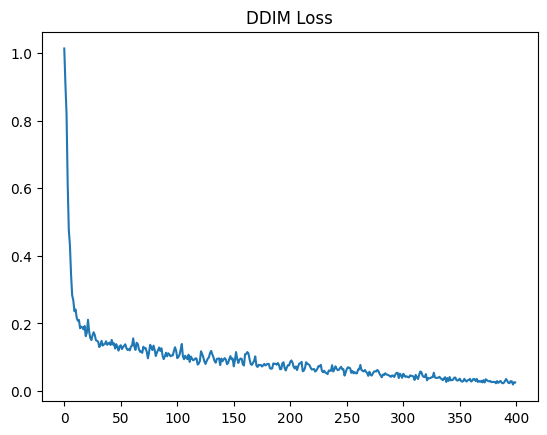

In [6]:
# ----- Train Diffusion Policy (DDIM) ----- #
# Instantiate the neural network
noise_pred_net = MLP(num_in=1, num_out=1, num_hid=100)

# Define the optimizer
ddim_optimizer = torch.optim.Adam(noise_pred_net.parameters(), lr=lr)
ddim_lr_scheduler = schedule_func(
    ddim_optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=Nsample // batch_size * num_epochs * 2)

# Instantiate and train the trainer
ddim_trainer = DDIMTrainer(
    net=noise_pred_net,
    dataloader=dataloader,
    optimizer=ddim_optimizer,
    lr_scheduler=ddim_lr_scheduler,
    num_epochs=num_epochs * 2,      # DDIM needs more epochs
    num_diff_steps=100,
    num_infer_steps=100, 
    scale_output=False, 
    )
ddim_loss_curve = ddim_trainer.train()

# Plot loss curve
plt.plot(ddim_loss_curve)
plt.title('DDIM Loss')
plt.show()

Epoch: 100%|██████████| 200/200 [00:18<00:00, 10.59it/s]


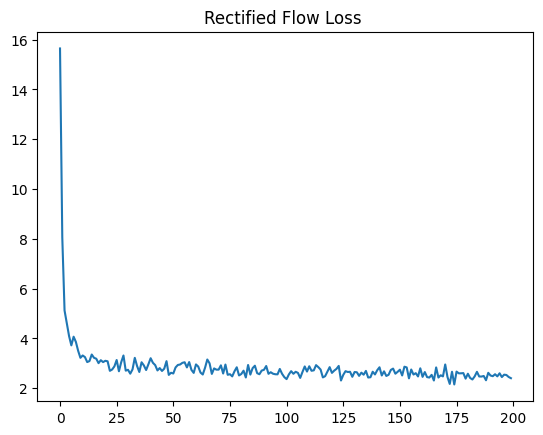

In [7]:
# ----- Train Rectified Flow ----- #
# Instantiate the neural network
vel_pred_net = MLP(num_in=1, num_out=1, num_hid=100)

# Define the optimizer
rf_optimizer = torch.optim.Adam(vel_pred_net.parameters(), lr=lr)
rf_lr_scheduler = schedule_func(
    rf_optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=Nsample // batch_size * num_epochs)

# Instantiate and train the trainer
rf_trainer = RFTrainer(
    net=vel_pred_net,
    dataloader=dataloader,
    optimizer=rf_optimizer,
    lr_scheduler=rf_lr_scheduler,
    num_epochs=num_epochs,
    num_infer_steps=100,
    # num_epochs=5,
)
rf_loss_curve = rf_trainer.train()
# Plot loss curve
plt.plot(rf_loss_curve)
plt.title('Rectified Flow Loss ')
plt.show()

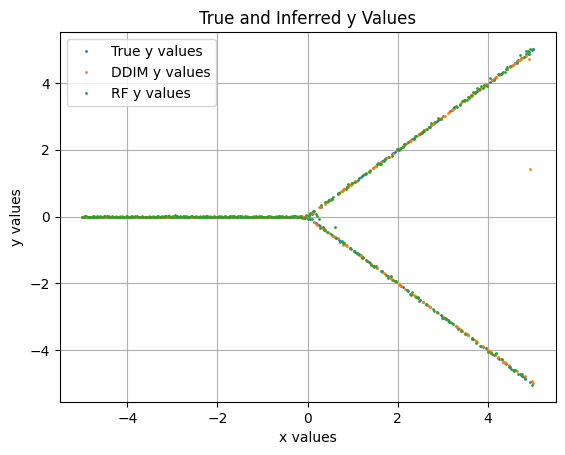

In [8]:
# ------- Let's visualize the true and inferred y values ------- #

# 1. Generate a set of unseen x values
Nsample = 333
x_unseen = np.linspace(-5, 5, Nsample)[:, np.newaxis].astype('float32')
x_tensor_unseen = torch.tensor(x_unseen, dtype=torch.float32)

# 2. Use the trained model to infer the y values corresponding to the unseen x values
y_inferred_ddim = ddim_trainer.infer_y(x_tensor_unseen)
y_inferred_rf = rf_trainer.infer_y(x_tensor_unseen)

# 3. Convert the inferred y values to a numpy array for easy handling
y_inferred_np_ddim = y_inferred_ddim.detach().cpu().numpy()
y_inferred_np_rf = y_inferred_rf.detach().cpu().numpy()

# 4. Plot the true y values and the inferred y values
plt.figure()

# Plot the true y values
y_true = np.array([ftrue(xi) for xi in x_unseen]).astype('float32')
plt.plot(x_unseen, y_true, ".", label='True y values', markersize=2)

# Plot the inferred y values
plt.plot(x_unseen, y_inferred_np_ddim, ".", label='DDIM y values', markersize=2)
plt.plot(x_unseen, y_inferred_np_rf, ".", label='RF y values', markersize=2)

plt.xlabel('x values')
plt.ylabel('y values')
plt.title('True and Inferred y Values')
plt.legend()
plt.grid(True)
plt.show()

It appears that both DDIM and 1-Rectified Flow have successfully predicted the value of this function.

Both models utilize an Euler sampler, which simulates the ODE by taking 100 steps (forward inference performed 100 times) to generate $y$. 

Let's now delve deeper into the differences between these two models during the generation process. By visualizing the generation trajectory, we will observe the predicted value $y_t$ at each inference step $t$. 


/tmp/ipykernel_738513/3846304416.py:15: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  noise = torch.range(start=start, end=end, step=(end-start)/(Nnoise-1)).repeat(Nsample).unsqueeze(-1).to(ddim_trainer.device)


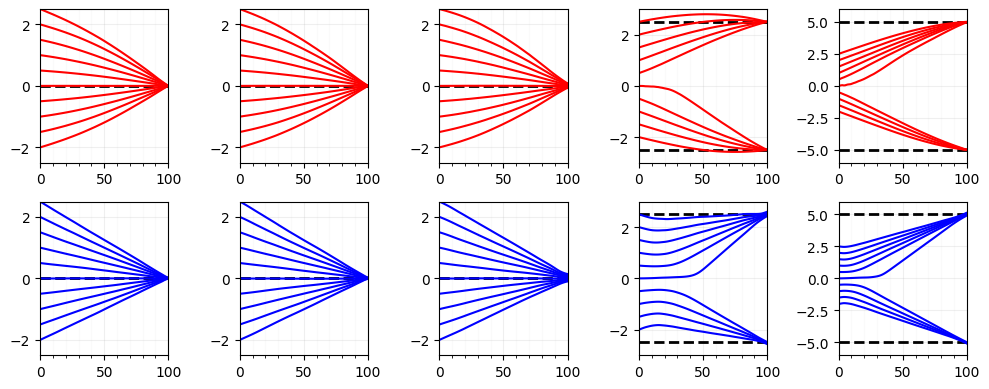

In [9]:
# Visualize y prediction v.s. inference step
infer_step = 100
Nsample = 5
Nnoise = 10
x_unseen = np.linspace(-5, 5, Nsample)[:, np.newaxis].astype('float32')
num_x = x_unseen.shape[0]

x_unseen_orig = x_unseen
x_unseen = np.repeat(x_unseen, Nnoise, axis=0)

x_tensor_unseen = torch.tensor(x_unseen, dtype=torch.float32)

end = 2.5
start = -2.0
noise = torch.range(start=start, end=end, step=(end-start)/(Nnoise-1)).repeat(Nsample).unsqueeze(-1).to(ddim_trainer.device)

ddim_trainer.num_infer_steps = infer_step
y_inferred_ddim = ddim_trainer.infer_y(
    x_tensor_unseen,
    return_traj=True, 
    noise=noise, 
    )
y_inferred_ddim = y_inferred_ddim.reshape(infer_step+1, num_x, Nnoise)
ddim_predy_traj = y_inferred_ddim.detach().cpu().numpy()

rf_trainer.num_infer_steps = infer_step
y_inferred_rf = rf_trainer.infer_y(
    x_tensor_unseen,
    return_traj=True, 
    noise=noise, 
    )
y_inferred_rf = y_inferred_rf.reshape(infer_step+1, num_x, Nnoise)
rf_predy_traj = y_inferred_rf.detach().cpu().numpy()

infer_step_np = np.array(list(range(infer_step+1)))
y_true = np.array([ftrue(xi) for xi in x_unseen_orig]).astype('float32')

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()  # Flatten the grid of axes to make indexing easier

for i in range(num_x * 2):
    if i % 5 < 3:
        axes[i].axhline(0, linestyle='--', color='k', linewidth=2.0)
    elif i % 5 == 3:
        axes[i].axhline(2.5, linestyle='--', color='k', linewidth=2.0)
        axes[i].axhline(-2.5, linestyle='--', color='k', linewidth=2.0)
    else:
        axes[i].axhline(5, linestyle='--', color='k', linewidth=2.0)
        axes[i].axhline(-5, linestyle='--', color='k', linewidth=2.0)
        

    for k in range(Nnoise):
        if i < 5:
          y_infer_i_ddim = ddim_predy_traj[:, i % 5, k]
          axes[i].plot(infer_step_np,
                        y_infer_i_ddim,
                        "-",
                        color="red",
                        markersize=2)
        else:
          y_infer_i_rf = rf_predy_traj[:, i % 5, k]
          axes[i].plot(infer_step_np,
                        y_infer_i_rf,
                        "-",
                        color="blue",
                        markersize=2)
    
    axes[i].grid(True)
    if i % 5 < 3:
        axes[i].set_ylim(-2.5, 2.5)
        axes[i].set_yticks([-2, 0, 2])
    elif i % 5 == 3:
        axes[i].set_ylim(-3, 3)
    else:
        axes[i].set_ylim(-6, 6)
    axes[i].set_xlim(0, 100)
    axes[i].xaxis.set_minor_locator(MultipleLocator(10.0))
    axes[i].grid(which='minor', alpha=0.05)
    axes[i].grid(which='major', alpha=0.2)

fig.subplots_adjust(hspace=0.05, wspace=0.05)

plt.tight_layout()
plt.show()

Here we found an interesting observation: the simulated ODE trajectory learned by Diffusion Policy with DDIM (red) is not straight no matter what x is. By contrast, the simulated ODE trajectory learned by AdaFlow with fixed step (blue) is a straight line when the prediction is deterministic (x ≤ 0), 

This means the generation can be exactly done by one-step Euler discretization, which inspired us to develop AdaFlow.  

We've made an intriguing observation: the simulated ODE trajectory learned by the Diffusion Policy with DDIM (depicted in red) is never straight, regardless of the value of $x$. In contrast, the trajectory learned by 1-RectifiedFlow with a fixed step (shown in blue) is a straight line when the prediction is deterministic $(x<0)$.

This behavior indicates that the generation process can be effectively executed with a one-step Euler discretization. This observation was a key inspiration in the development of AdaFlow.

## 2. AdaFlow

In AdaFlow, we learn a variance prediction network that indicates the straightness of the ODE trajectory. This capability enables us to adopt an adaptive strategy for setting the step size, which in turn, allows us to achieve more accurate estimations with less steps during inference.

In [10]:
# ---- AdaFlow ---- #
class AdaFlowTrainer(BaseTrainer): 
    def __init__(self, var_model=None, var_optimizer=None, var_lr_scheduler=None, num_infer_steps=5, *args, **kwargs):
        super(AdaFlowTrainer, self).__init__(*args, **kwargs)
        self.var_model = var_model
        self.var_optimizer = var_optimizer
        self.var_lr_scheduler = var_lr_scheduler
        self.num_infer_steps = num_infer_steps
        self.pos_emb_scale = 20

        self.var_model.to(self.device)

    def get_train_tuple(self, z0=None, z1=None):
        t = torch.rand(z1.shape[0], 1).to(self.device)
        z_t =  t * z1 + (1.-t) * z0
        target = z1 - z0

        return z_t, t, target

    def train(self):
        losses = list()

        with tqdm(range(self.num_epochs), desc="Epoch") as tglobal:
            # epoch loop
            for epoch_idx in tglobal:
                epoch_loss = list()
                for step_i, nbatch in enumerate(self.dataloader):
                    nx, ny = nbatch
                    nx = nx.to(self.device)
                    ny = ny.to(self.device)
                    loss = self.get_loss(nx, ny)

                    loss.backward()
                    self.var_optimizer.step()
                    self.var_optimizer.zero_grad()
                    self.var_lr_scheduler.step()

                    loss_cpu = loss.item()
                    epoch_loss.append(loss_cpu)
                losses.append(np.mean(epoch_loss))
        return losses
    
    def get_loss(self, nx, ny, return_rf_loss=False):
        if self.scale_output:
            ny = ny / self.y_max
        B = nx.shape[0]
        noise = torch.randn(ny.shape).to(self.device)
        z_t, t, target = self.get_train_tuple(z0=noise, z1=ny)

        vel_pred = self.net(z_t, t.squeeze()*self.pos_emb_scale, cond=nx)
        
        if return_rf_loss: 
            loss = nn.functional.mse_loss(vel_pred, target)
            return loss

        log_sqrt_var_pred = self.var_model(nx, t.squeeze()*self.pos_emb_scale).squeeze()

        error = (target - vel_pred).view(B, -1).abs().pow(2).sum(dim=1)
        loss = 1 / (2. * torch.exp(2 * log_sqrt_var_pred)) * error + log_sqrt_var_pred
        loss = loss.mean()
        
        return loss
    
    @torch.no_grad()
    def infer_y_euler(self, nx, y_dim=1, use_default_noise=False, return_traj=False):
        nx = nx.to(self.device)
        self.net.eval()
        B = nx.shape[0]

        noise = torch.randn((B, y_dim)).to(self.device)

        z = noise
        if self.scale_output:
            traj = [z * self.y_max]
        else:
            traj = [z]

        var_traj = []
        for i in range(self.num_infer_steps):
            t = torch.ones((B)).to(self.device) * i / self.num_infer_steps
            vel_pred = self.net(z, t * self.pos_emb_scale, cond=nx)
            var_pred = self.var_model(nx, t * self.pos_emb_scale).exp() ** 2

            z = z.detach().clone() + vel_pred * (1 / self.num_infer_steps)
            if self.scale_output:
                traj.append(z * self.y_max)
            else:
                traj.append(z)
            var_traj.append(var_pred)

        if return_traj:
            return torch.stack(traj), torch.stack(var_traj)
        return traj[-1], torch.stack(var_traj)
    
    @torch.no_grad()
    def infer_y(self, nx, y_dim=1, noise=None, return_traj=False, step_size_hyper=None, N=None):
        if N is not None: 
            num_infer_steps = N
        else: 
            num_infer_steps = self.num_infer_steps
            
        nx = nx.to(self.device)
        self.net.eval()
        B = nx.shape[0]
        if noise is None:
            noise = torch.randn((B, y_dim)).to(self.device)
        
        step_traj = [0] # to store the step size along the trajectory
        z = noise
        if self.scale_output:
            traj = [z * self.y_max]
        else:
            traj = [z]

        current_t = 0
        for i in range(num_infer_steps):
            t = torch.ones((B)) * current_t
            t = t.to(self.device)

            vel_pred = self.net(z, t * self.pos_emb_scale, cond=nx)

            # determine step size
            var_pred = self.var_model(nx, t).exp() ** 2
            step_size = min(max(step_size_hyper / var_pred.sqrt().item(), 1 / num_infer_steps), 1 - current_t)

            z = z.detach().clone() + vel_pred * step_size
            if self.scale_output:
                traj.append(z * self.y_max)
            else:
                traj.append(z)


            current_t = current_t + step_size
            step_traj.append(current_t)
            if current_t >= 1: 
                break

        if return_traj:
            return torch.stack(traj), step_traj
        return traj[-1]

Epoch: 100%|██████████| 200/200 [00:22<00:00,  8.72it/s]


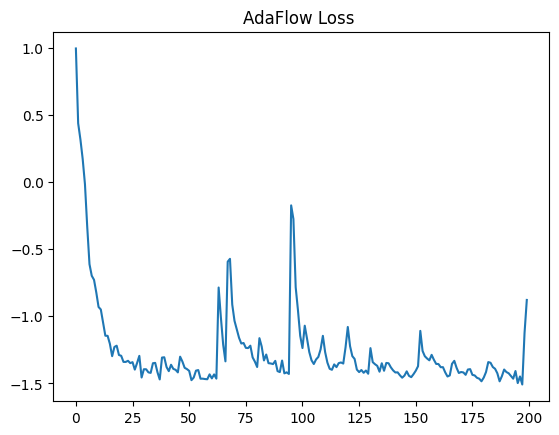

In [11]:
class VarMLP(nn.Module):
    def __init__(
        self,
        num_in,
        num_out,
        num_hid=500,
        ):
        super().__init__()
        self.num_in = num_in
        self.num_hid = num_hid
        self.num_out = num_out

        self.rdFrequency = torch.normal(0, 1, (1, 100))

        self.net = nn.Sequential(
            nn.Linear(num_in + 100 , num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_out)
        )

    def forward(self, cond, timesteps):
        # add noise onto the condition
        if not torch.is_tensor(timesteps):
            timesteps = torch.tensor([timesteps]).to(cond)
        timesteps = timesteps.expand(cond.shape[0]).to(cond)
        time_feature = torch.cos(
            torch.matmul(timesteps.unsqueeze(-1), self.rdFrequency.to(timesteps)))
        x_in = torch.cat([cond, time_feature], dim=-1)
        out = self.net(x_in)
        return out

rf_model = MLP(num_in=1, num_out=1, num_hid=100)
var_est_model = VarMLP(num_in=1, num_out=1, num_hid=100)
# For simplicity, we reuse the 1-Rectified Flow model trained before
# But we can also train a new model from scratch
rf_model.load_state_dict(rf_trainer.net.state_dict())   
rf_model.rdFrequency = rf_trainer.net.rdFrequency

var_optimizer = torch.optim.Adam(var_est_model.parameters(), lr=0.5 * lr)

# Define the lr scheduler for Varirance Estimator
var_lr_scheduler = schedule_func(
    var_optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=Nsample // batch_size * num_epochs)

adaflow_trainer = AdaFlowTrainer(
    net=rf_model, 
    var_model=var_est_model, 
    dataloader=dataloader,
    optimizer=None, 
    var_optimizer=var_optimizer, 
    lr_scheduler=None, 
    var_lr_scheduler=var_lr_scheduler, 
    num_epochs=num_epochs,
    num_infer_steps=100, 
    )

adaflow_loss_curve = adaflow_trainer.train()

# Plot loss curve
plt.plot(adaflow_loss_curve)
plt.title('AdaFlow Loss ')
plt.show()

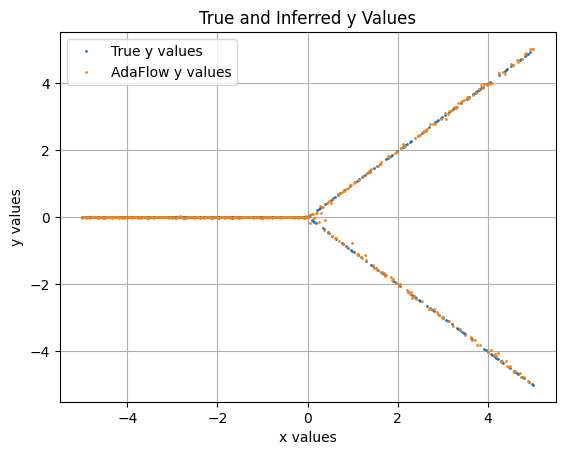

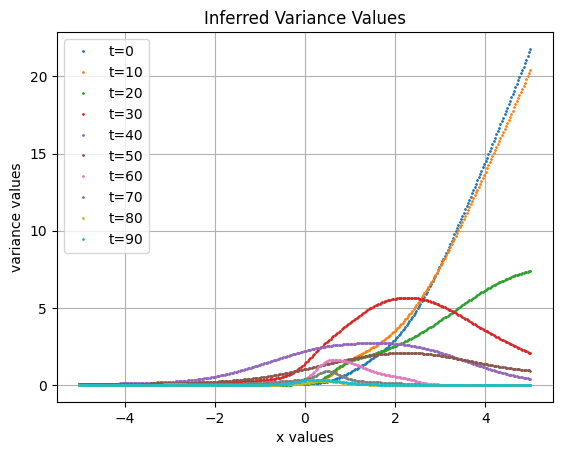

In [12]:
# 1. Generate a set of unseen x values
Nsample = 333
x_unseen = np.linspace(-5, 5, Nsample)[:, np.newaxis].astype('float32')
x_tensor_unseen = torch.tensor(x_unseen, dtype=torch.float32)

# 2. Use the trained model to infer the y values corresponding to the unseen x values
y_inferred_adaflow, var_adaflow = adaflow_trainer.infer_y_euler(x_tensor_unseen)

# 3. Convert the inferred y values to a numpy array for easy handling
y_inferred_np_adaflow = y_inferred_adaflow.detach().cpu().numpy()
var_np_es_rf = var_adaflow.detach().cpu().numpy()

# 4. Plot the true y values and the inferred y values
plt.figure()

# Plot the true y values
y_true = np.array([ftrue(xi) for xi in x_unseen]).astype('float32')
plt.plot(x_unseen, y_true, ".", label='True y values', markersize=2)

# Plot the inferred y values
plt.plot(x_unseen, y_inferred_np_adaflow, ".", label='AdaFlow y values', markersize=2)

plt.xlabel('x values')
plt.ylabel('y values')
plt.title('True and Inferred y Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()

# Plot the true y values
T = var_np_es_rf.shape[0]
for t in range(T): 
    if t % 10 == 0:
        plt.plot(x_unseen, var_np_es_rf[t], ".", label=f't={t}', markersize=2)

plt.xlabel('x values')
plt.ylabel('variance values')
plt.title('Inferred Variance Values')
plt.legend()
plt.grid(True)
plt.show()

We can see that AdaFlow predicts high variance for $x>0$

Using the learned variance, we can let AdaFlow adaptively choose how many steps to take for generation, as outlined in Algorithm 2 of the paper.

/tmp/ipykernel_738513/2068861881.py:13: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  noise = torch.range(start=start, end=end, step=(end-start)/(Nnoise-1)).repeat(Nsample).unsqueeze(-1).to(adaflow_trainer.device)
/tmp/ipykernel_738513/2068861881.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # Choose any colormap you like


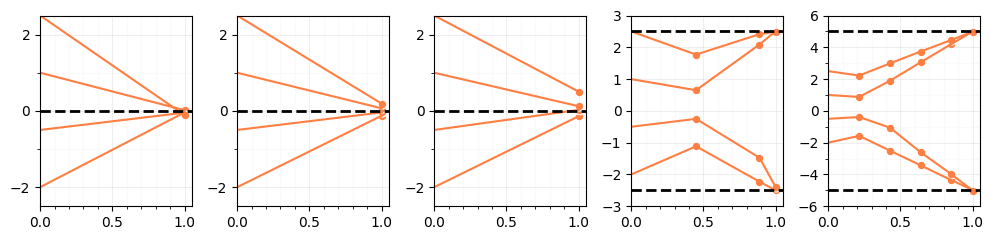

In [13]:
Nsample = 5
Nnoise = 4
x_unseen = np.linspace(-5, 5, Nsample)[:, np.newaxis].astype('float32')
num_x = x_unseen.shape[0]

x_tensor_unseen = torch.tensor(x_unseen, dtype=torch.float32)

es_rf_pred_traj = []
step_adaflow = []

end = 2.5
start = -2.0
noise = torch.range(start=start, end=end, step=(end-start)/(Nnoise-1)).repeat(Nsample).unsqueeze(-1).to(adaflow_trainer.device)

# generate y values
for x_i in x_tensor_unseen: 
    x_i = x_i.unsqueeze(0)
    trajs_i = []
    steps_i = []
    for k in range(Nnoise): 
        traj, steps = adaflow_trainer.infer_y(x_i, return_traj=True, noise=noise[k:k+1], step_size_hyper=1.0, N=5)
        trajs_i.append(traj.detach().cpu().squeeze().numpy())
        steps_i.append(np.array(steps))

    es_rf_pred_traj.append(trajs_i)
    step_adaflow.append(steps_i)

# visualize the generated y_t values
max_length = 1
min_length = 0
norm = plt.Normalize(min_length, max_length+0.2)
cmap = cm.get_cmap('rainbow')  # Choose any colormap you like

fig, axes = plt.subplots(1, Nsample, figsize=(10, 2.5))
axes = axes.ravel()

for i in range(len(step_adaflow)):
        
    step_mean = np.mean([len(step_adaflow_i)-1 for step_adaflow_i in step_adaflow[i]])
    for k in range(len(step_adaflow[i])):
        for j in range(len(step_adaflow[i][k])-1):
            segment_length = step_adaflow[i][k][j+1] - step_adaflow[i][k][j]
            color = cmap(norm(1))
            label = None
            if i == 0 and k == 0 and j == 0:
                label = 'AdaFlow'
                
            axes[i].plot(step_adaflow[i][k][j:j+2], es_rf_pred_traj[i][k][j:j+2], "-", label=label, color=color, markersize=2)
            
            # add step dots
            axes[i].scatter(step_adaflow[i][k][j+1:j+2],
                        es_rf_pred_traj[i][k][j+1:j+2],
                        marker="o",
                        edgecolor='white', facecolors=color, 
                        s=40)
    
    axes[i].grid(True)
    
    if i % 5 < 3:
        axes[i].set_ylim(-2.5, 2.5)
        axes[i].set_yticks([-2, 0, 2])
    elif i % 5 == 3:
        axes[i].set_ylim(-3, 3)
    else:
        axes[i].set_ylim(-6, 6)
    axes[i].set_xlim(0, 1+0.05)
    axes[i].xaxis.set_minor_locator(MultipleLocator(0.5/5))
    axes[i].yaxis.set_minor_locator(MultipleLocator(1.0))
    axes[i].grid(which='minor', alpha=0.05)
    axes[i].grid(which='major', alpha=0.2)
    
    if i % 5 < 3:
        axes[i].axhline(0, linestyle='--', color='k', linewidth=2.0)
    elif i % 5 == 3:
        axes[i].axhline(2.5, linestyle='--', color='k', linewidth=2.0)
        axes[i].axhline(-2.5, linestyle='--', color='k', linewidth=2.0)
    else:
        axes[i].axhline(5, linestyle='--', color='k', linewidth=2.0)
        axes[i].axhline(-5, linestyle='--', color='k', linewidth=2.0) 
        
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.tight_layout()

plt.show()



We can see that for deterministic generation where $x<0$, AdaFlow uses 1 steps for generation, while for $x>0$, it automatically uses more steps to generate accurately. 